# Pricing and Effects of Parameters in the Heston Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
plt.style.use('fivethirtyeight')

In [2]:
from Models.Heston import Heston
from Models.BlackScholes import BlackScholes

The module `Models.Heston` implements option pricing for a european call option under the Heston model. The signature of the `Heston` class is $(r, v_0, \kappa, \theta, \eta, \rho, \sigma)$ where

* $r$ is the risk-free rate;
* $v_0$ is the initial volatility level;
* $\kappa$ is the volatility mean-reversion rate;
* $\theta$ is the long-term volatility level;
* $\eta$ is the volatility risk parameter;
* $\rho$ is the correlation between the Brownian motions in the stock price and volatiltiy processes;
* $\sigma$ is the vol-of-vol.

We give an example call below.

In [3]:
heston = Heston(0.03, 0.05, 5, 0.05, 0, -0.8, 0.5)

In computing the call price, we have opted to use the Gil-Pelaez theorem to compute the probabiltities (under different measures) through the characteristic function. We thus have easy access to the characteristic funcions of the Heston models:

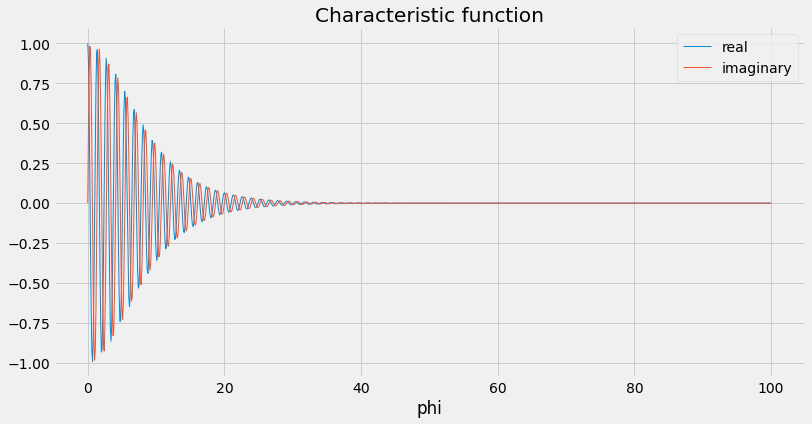

In [4]:
fig, ax = plt.subplots(figsize = (12, 6))
phis = np.linspace(1e-8, 1e2, 1000)
_, psi = heston.makeCharacteristicFunctions(100, 0.5, 0)
re = [psi(q).real for q in phis]
im = [psi(q).imag for q in phis]
ax.plot(phis, re, linewidth = 1, label = f'real')
ax.plot(phis, im, linewidth = 1, label = f'imaginary')
    
ax.set_title(f'Characteristic function')
ax.legend(loc = 'best')
ax.set_xlabel('phi')
plt.show()

We shall be using this extensively to specify the domain of integration in computing Fourier transforms etc. In the example above, we see that the characeteristic function has decayed by $\phi = 50$ and so we can truncate any integrations to lie in the range $\phi \in (0, 50]$.

The main purpose of the `Heston` class is to compute the arbitrage-free price of European options and we give examples of pricing both call and put options on an underlying with and without dividends (at rate `q`).

In [5]:
strike_price = 100
spot_price = 100
time_to_maturity = 0.5
r = 0.03
q = 0.02
lower = 1e-5
upper = 50
print(heston.getPutPrice(strike_price, spot_price, time_to_maturity, q, lower, upper))
print(heston.getCallPrice(strike_price, spot_price, time_to_maturity, q, lower, upper))
print(heston.getPutPrice(strike_price, spot_price, time_to_maturity, 0., lower, upper))
print(heston.getCallPrice(strike_price, spot_price, time_to_maturity, 0., lower, upper))

5.759029574965297
6.252818989575843
5.3790287734613145
6.867834813155056


## Effect of Correlation on Log-Terminal Stock Price

The parameter $\rho$ is introduced as a correlation coefficient between the two Brownian motions in the stock price and the its volatility. Here, we shall study the effect of $\rho$ on the distribution of the log terminal stock price by considering 3 different values correponding to strong negative correlation, no correlation and strong positive correlation:

In [6]:
rho_vals = [-0.8, 0, 0.8]

# Initialise three Heston models with these correlations, whilst
# keeping all other paramters fixed.
models = [Heston(0., 0.01, 2, 0.01, 0, rho, 0.1) for rho in rho_vals]
stock_price = np.linspace(50,150, 200)
log_stock_price = [np.log(S) for S in stock_price]

Since our implementation the pdf involves taking the inverse Fourier transform of the characteristic function, we need to work out a sufficient truncation for the upper limit of the integral. This is done by checking the behaviour of the characterstic functions of each model and choosing an upper limit beyond which the integrand is negligible.

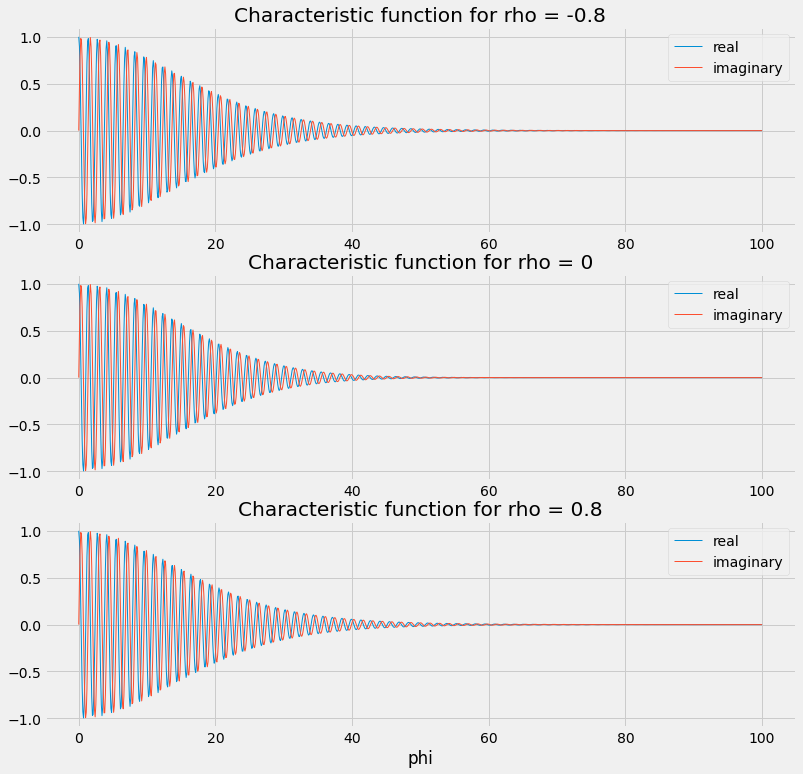

In [7]:
fig, ax = plt.subplots(nrows = 3, figsize = (12, 12))
phis = np.linspace(1e-8, 1e2, 1000)

# Plot the real and imaginary parts of the characteristic functions of each model
for k in range(len(models)):
    heston = models[k]
    _, psi = heston.makeCharacteristicFunctions(100, 0.5, 0)
    re = [psi(q).real for q in phis]
    im = [psi(q).imag for q in phis]
    ax[k].plot(phis, re, linewidth = 1, label = f'real')
    ax[k].plot(phis, im, linewidth = 1, label = f'imaginary')
    
    ax[k].set_title(f'Characteristic function for rho = {heston.rho}')
    ax[k].legend(loc = 'best')
ax[-1].set_xlabel('phi')
plt.show()

Since both the real and imaginary parts of the characteristic function decay very quickly for each of the models, we can limit the range of integration over $\phi$ to $[10^{-8}, 100]$, say, without losing too much precision.

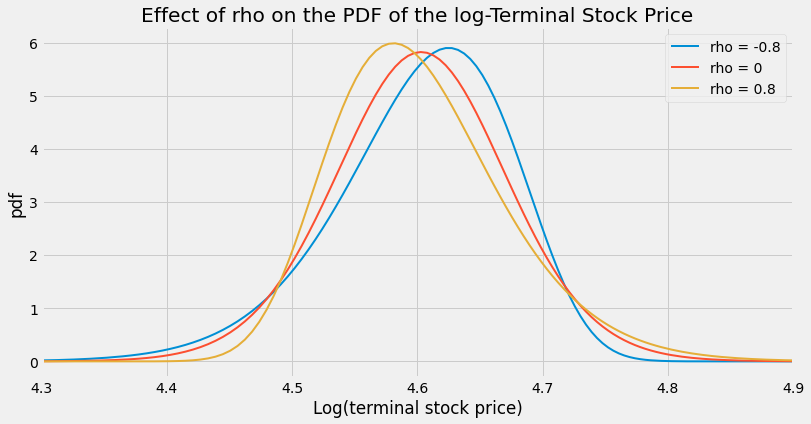

In [8]:
fig, ax = plt.subplots(figsize = (12, 6))

lower = 1e-8
upper = 1e2

# Plot the pdf of the logarithmic terminal stock price
for heston in models:
    label = f'rho = {heston.rho}'
    pdf = [heston.getDensity(100, 0.5, x, lower, upper) for x in log_stock_price]
    ax.plot(log_stock_price, pdf, linewidth = 2 , label = label)

# Add Information
ax.set_xlim(4.3, 4.9)
ax.set_title('Effect of rho on the PDF of the log-Terminal Stock Price')
ax.set_xlabel('Log(terminal stock price)')
ax.set_ylabel('pdf')
ax.legend(loc = 'best')

# Show the plot
plt.show()

We see that the parameter $\rho$ plays the role of skewness; the orange line with $\rho = 0.8$ has a fatter tail beyond the mode, which has been pushed back slightly relative to the red line representing no skew. This is roughly Figure 1 of Heston's original paper, but without the normalisation.

Note that the peak of the $\rho = 0$ line occurs at $\ln 100 \approx 4.6$.

## Effect of Vol-of-vol on Log-Terminal Stock Price

The parameter $\sigma$ in the Heston model represents the volatility of the stochastic volatility process. Below, we illustrate the effect of changing the values of $\sigma$. Note that $\sigma = 0$ is not allowed since this would result in an entirely deterministic (albeit time-dependent) volatility process.

In particular, trying to set $\sigma = 0$ alone does not reduce to the Black-Scholes model; that requires further setting $\theta = \sqrt{v_0}$ in order to construct a constant volatility model with $\sigma_{\text{BS}} = \sqrt{v_0}$. The result of this is a different set of equations governing the characteristic function, rather than the full Ricatti equation, that needs to be solved separately.

In [9]:
# we consider 3 values of sigma
sigma_vals = [0.0001, 0.2, 0.4]
models = [Heston(0., 0.01, 2, 0.01, 0., 0., sigma) for sigma in sigma_vals]

As before, we check the behaviour of the charateristic function to determine a suitable upper limit for the Fourier inversion:

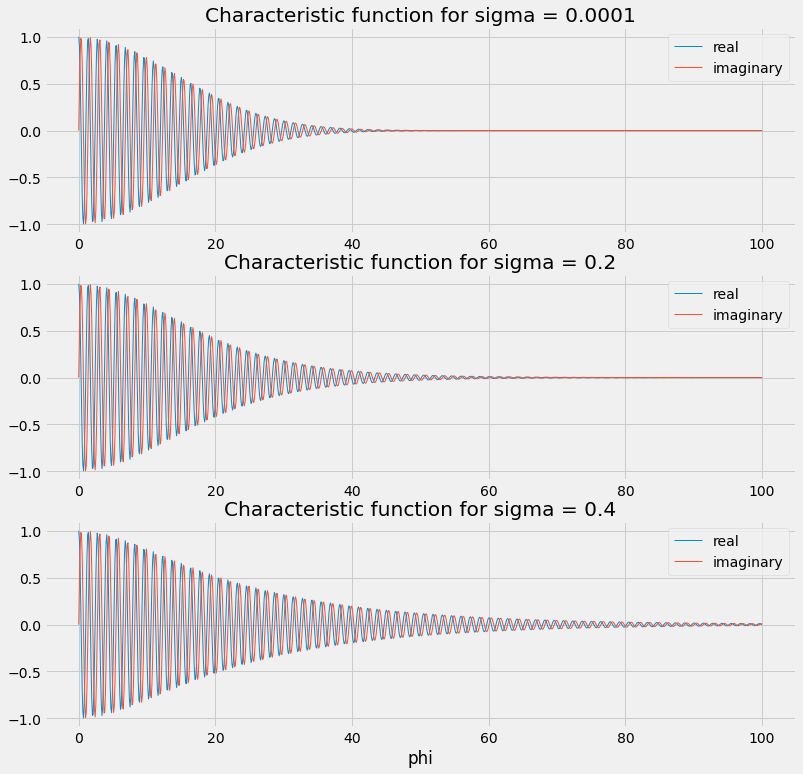

In [10]:
fig, ax = plt.subplots(nrows = 3, figsize = (12, 12))
phis = np.linspace(1e-8, 1e2, 1000)
for k in range(len(models)):
    heston = models[k]
    _, psi = heston.makeCharacteristicFunctions(100, 0.5, 0)
    re = [psi(q).real for q in phis]
    im = [psi(q).imag for q in phis]
    ax[k].plot(phis, re, linewidth = 1, label = f'real')
    ax[k].plot(phis, im, linewidth = 1, label = f'imaginary')
    
    ax[k].set_title(f'Characteristic function for sigma = {heston.sigma}')
    ax[k].legend(loc = 'best')
ax[-1].set_xlabel('phi')
plt.show()

Evidently, a higher vol-of-vol causes the characteristic function to decay slower. The last model is still visibly oscillating at $\phi = 100$ and so we shall extend the domain of integration in the inversion to the p.d.f. to $[10^{-8}, 200]$ to accomodate this.

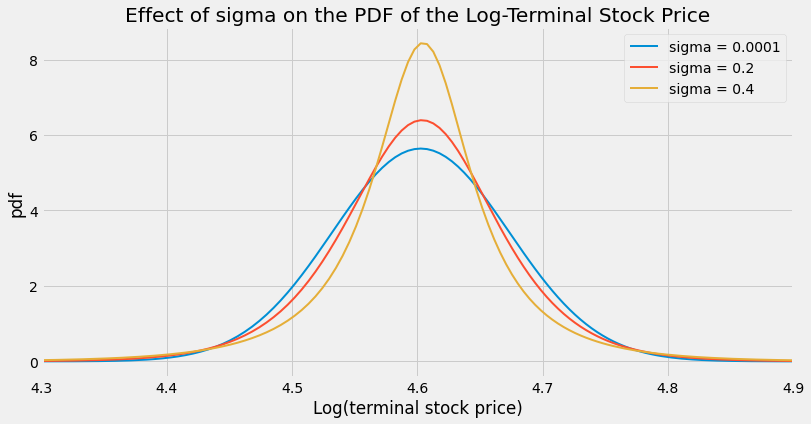

In [11]:
fig, ax = plt.subplots(figsize = (12, 6))

lower = 1e-8
upper = 2e2

# Plot the pdf of the logarithmic terminal stock price
for heston in models:
    label = f'sigma = {heston.sigma}'
    pdf = [heston.getDensity(100, 0.5, x, lower, upper) for x in log_stock_price]
    ax.plot(log_stock_price, pdf, linewidth = 2 , label = label)

# Add Information
ax.set_xlim(4.3, 4.9)
ax.set_title('Effect of sigma on the PDF of the Log-Terminal Stock Price')
ax.set_xlabel('Log(terminal stock price)')
ax.set_ylabel('pdf')
ax.legend(loc = 'best')

# Show the plot
plt.show()

We see that vol-of-vol controls the kurtosis of the distribution of the log-terminal stock price since a higher vol-of-vol corresponds to a more dispersed volatility and hence fatter tails. Indeed, one sees that the tails of both  the red and oragne lines lie strictly above the tails of the blue $\sigma = 0.0001$ line. This is roughly Figure 3 of Heston's original paper, but without the normalisation.

These last two figures illustrate that one of the benefits of introducing a stochastic volatility process is that it introduces extra parameters that can introduce skewness and kurtosis into the log-stock price that the Black-Scholes model fails to describe. Indeed, in the brief description outlined above, it is evident that both $\rho$ and $\sigma$ drop out of the model in the reduction to the Black-Scholes model and so they must both control aspects beyond what the Black-Scholes model can describe.

## Correlation in the Heston Model v.s. no Correlation in the Black-Scholes Model

Here, we consider the pricings that a Heston model and a comparable Black-Scholes model assign to a given set of boundary conditions. We shall use the standard deviation of the log terminal stock prices of the Heston model as an estimate of the volatility parameter $\sigma_{\text{BS}}$ of a Black-Scholes option with the same boundary conditions as the Heston option:

$$
\sigma_{\text{BS}} \approx \text{std} (\ln S_T)\,,
$$

i.e. the characteristic width of the p.d.f. above. Note that this is *not* the terminal variance $\sqrt{v_T}$, which we have not modelled. We have already obtained the characteristic function $\psi(\phi)$ of the log terminal stock price $x_T = \ln S_T$ in the Heston model and so we can use the following relation to estimate the moments of $x_T$ and hence $\sigma_{\text{BS}}$:

$$
\mathbb{E}[x_T^n] = \frac{1}{i^n} \frac{\textrm{d}^n \psi}{\textrm{d} \phi^n} \biggr|_{\phi = 0}\,.
$$

We approximate this numerically by (central) finite differences about $\psi(0)$.

In [12]:
def getBlackScholesVolatility(heston, strike, tau, delta = 1e-4):
    """
    Estimate the volatility parameter for a Black-Scholes model with the same
    boundary conditions as the Heston model.
    
    Note that we only need the second characteristic function since we only need
    the width of the pdf under the risk-neutral measure.
    
    Parameters
    ----------
    heston : Heston
        The Heston model with which to estimate the Black-Scholes volatility with.
    strike : float
        Strike price of option.
    tau : float
        Time to expiry (years).
    delta : float
        Step-size to use in the finite-differences method.

    Returns
    -------
    float
        Estimated volatility of the Black-Scholes option.
    """
    _, psi = heston.makeCharacteristicFunctions(strike, tau)
    
    # First and second finite (central) differences for first and second derivatives
    # of the characteistic function.
    ex = 1. / 1j * (psi(delta) - psi(-delta)) / (2 *delta)
    ex2 = -1 * (psi(2 * delta) - 2* psi(0) + psi(- 2 * delta))/ (4 * delta**2)
    return np.sqrt(2) * np.sqrt(ex2 - ex **2).real

We now use these to estimate the pricing difference between the Heston model and the comparable Black-Scholes for two values of correlation $\rho$.

In [13]:
# Parameters for the option
strike = 100
tau = 0.5
spot_prices = np.linspace(70, 140, 100)

# Construct two Heston models with correlations -0.5 and 0.5.
correlations = [-0.5, 0.5]
hestons = [Heston(0., 0.01, 2, 0.01, 0., rho, 0.1) for rho in correlations]

# For each Heston model, construct a comparable Black-Scholes model.
black_scholes = [BlackScholes(0., getBlackScholesVolatility(heston, strike, tau)) for heston in hestons]

By an analysis similar to the one above, one may varify that the characteristic function has decayed sufficiently for convergence of the integral by $\phi = 100$ and so, once again, we limit the domain of integration to $[10^{-8}, 100]$. Using each of the models, we compute the call prices for a range of spot prices at fixed horizon $\tau = 0.5 \text{ years}$:

In [14]:
lower = 1e-8
upper = 1e2

h_prices_1 = [hestons[0].getCallPrice(100, S, 0.5, lower = lower, upper = upper) for S in spot_prices]
h_prices_2 = [hestons[1].getCallPrice(100, S, 0.5, lower = lower, upper = upper) for S in spot_prices]
bs_prices_1 = [black_scholes[0].getCallPrice(100, S, 0.5) for S in spot_prices]
bs_prices_2 = [black_scholes[1].getCallPrice(100, S, 0.5) for S in spot_prices]

# Compute the difference between the Heston and Black-Scholes pricings under the two correlations
diff_1 = [a - b for a, b in zip(h_prices_1, bs_prices_1)]
diff_2 = [a - b for a, b in zip(h_prices_2, bs_prices_2)]

The plot below demonstrates the difference in valuation that the Heston and Black-Scholes models assign to the option for different correlations:

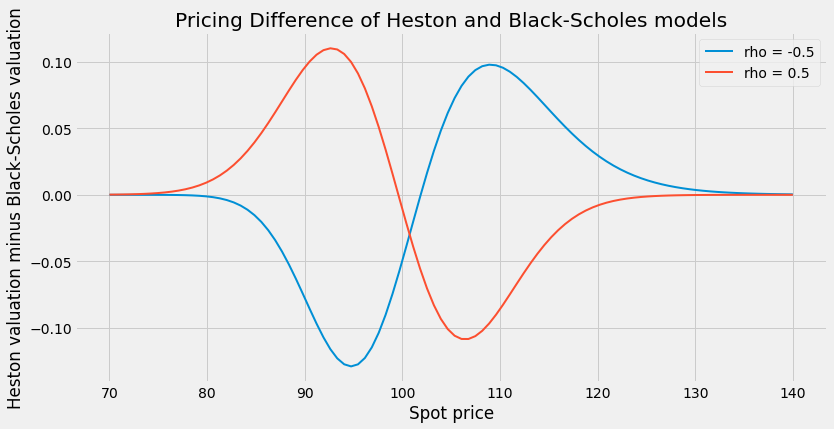

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(spot_prices, diff_1, linewidth = 2, label = f'rho = {correlations[0]}')
ax.plot(spot_prices, diff_2, linewidth = 2, label = f'rho = {correlations[1]}')
ax.set_title('Pricing Difference of Heston and Black-Scholes models')
ax.set_xlabel('Spot price')
ax.set_ylabel('Heston valuation minus Black-Scholes valuation')
ax.legend(loc = 'best')

This is rougly Figure 2 of Heston's original paper.

We see that, for positive correlation, the Heston model prices OTM (at $\tau = 0.5$ years) options higher than the Black-Scholes model does due to the positive skew of the distribution increasing the chaces of eventually landing ITM at maturity. Conversely, ITM options at $\tau = 0.5$ years are priced lower in the Heston model with negative correlation due to an increased chance of landing OTM at maturity.

Note that the asymmetry of the plot is a result of the 'comparable' Black-Scholes model changing with the spot price; in particular at spot price $S_t = 70$, the function `getBlackScholesVolatility()` suggests $\sigma_{\text{BS}} = \sqrt{2} \times 0.0710$ but at spot $S_t = 140$, it suggests $\sigma_{\text{BS}} = \sqrt{2} \times 0.0704$.

## Vol-of-vol in the Heston Model v.s. Constant volatility in the Black-Scholes Model

We now consider the effect of the vol-of-vol on option valuation betweeen the Heston models and comparable (as defined above) Black-Scholes models for two different values of $\sigma$.

In [16]:
sigmas = [0.1, 0.2]
hestons = [Heston(0., 0.01, 2, 0.01, 0., 0., sigma) for sigma in sigmas]
black_scholes = [BlackScholes(0., getBlackScholesVolatility(heston, strike, tau)) for heston in hestons]

Checking the decay of the characteristic function suggests that we may truncate the domain of integration to $[10^{-8}, 100]$ without loss of too much precision.

As before, we set up all the relevant models and compute the valuation difference between the Heston and Black-Scholes models:

In [17]:
lower = 1e-8
upper = 1e2

h_prices_1 = [hestons[0].getCallPrice(100, S, 0.5, 0., lower, upper) for S in spot_prices]
h_prices_2 = [hestons[1].getCallPrice(100, S, 0.5, 0., lower, upper) for S in spot_prices]
bs_prices_1 = [black_scholes[0].getCallPrice(100, S, 0.5) for S in spot_prices]
bs_prices_2 = [black_scholes[1].getCallPrice(100, S, 0.5) for S in spot_prices]
diff_1 = [a - b for a, b in zip(h_prices_1, bs_prices_1)]
diff_2 = [a - b for a, b in zip(h_prices_2, bs_prices_2)]

Plotting the difference reveals the effect of kurtosis on the valuation.

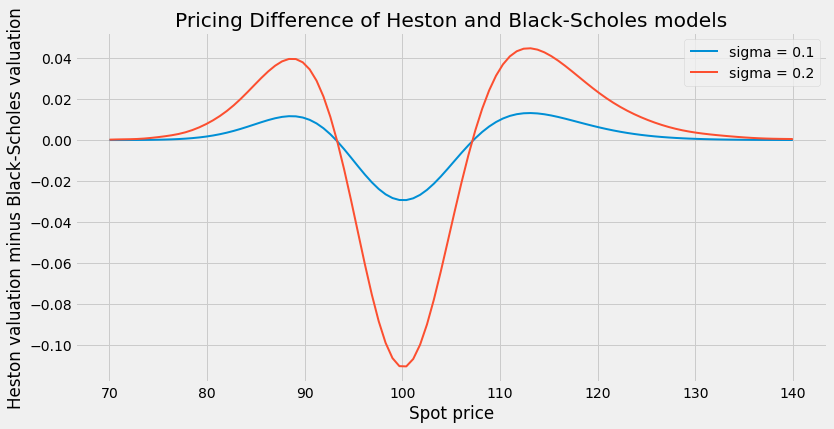

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(spot_prices, diff_1, linewidth = 2, label = f'sigma = {hestons[0].sigma}')
ax.plot(spot_prices, diff_2, linewidth = 2, label = f'sigma = {hestons[1].sigma}')
ax.set_title('Pricing Difference of Heston and Black-Scholes models')
ax.set_xlabel('Spot price')
ax.set_ylabel('Heston valuation minus Black-Scholes valuation')
ax.legend(loc = 'best')

We see that higher kurtosis raises the valuation of the option under the Heston model, relative to the Black-Scholes model, in the OTM and ITM regions but depresses the valuation at-the-money. Focusing on the peak in the OTM region, this suggests that the increased probability of landing ITM on account of a fatter right tail outweighs the increased probability of landing further OTM on account of the fatter left tail, which makes intuitive sense. Similar argumetns hold for the peak in the ITM region. However, the trough at-the-money arises due to the higher risk associated with a more dispersed volatility process.

## Implied Volatility in the Heston Model

One of the central reasons for introducing stochastic volatility is to describe the so-caled **volatility smile** of the **implied volatility** observed in market data. Under the Black-Scholes model, all of the parameters except the volatiltiy $\sigma_{\text{BS}}$ are either determined by the option contract (strike $K$ and maturity $T$) or can be obtained from the market data (stock price $S_t$ annd option price $C_t$) and so we can compute the implied volatilty $\sigma_{\text{imp}}$ as the volatiltiy required to match the option price to the observed market price:

$$
C^{\text{BS}}(S, K, \tau; \sigma_{\text{imp}}) = C^{\text{mkt}}\,.
$$

Doing so for a range of strike prices produces a characteristic up-turned smile that cannot be captured by a Black-Scholes model. Part of the power of the Heston model is that it is a semi-analytic tractable model that has a volatility smile built-into it. Here, we shall study the effects of the various parameters on this volatility smile.

The main piece of code for this section is given below:

In [19]:
def impliedVolatility(heston, K, S, tau, q = 0., lower = 1e-8, upper = 250):
    """
    Computes the implied volatility of a call option under the Heston model.
    In the case of the Heston model, we define the implied volatitily as the
    volatility of a Black-Scholes model which matches the option price to the
    price under the Heston model.
    
    Parameters
    ----------
    heston : Heston
        The Heston model whose volatility smile we comopute.
    K : float
        Strike price of the option
    S : float
        Spot price
    tau : float
        Time to maturity (years)
    q : float, optional
        Stock dividend rate
    lower : float
        Lower Limit of integration
    upper : float
        Upper limit of integration
    
    Returns
    -------
    float
        The implied volatility of the option at strike K
    """
    heston_price = heston.getCallPrice(K, S, tau, q, lower, upper)
    def getFunction():
        """
        Helper function that returns a callable that computes the
        difference between the Black-Scholes price and Heston price
        at the given volatility.
        """
        def function(sigma):
            bs = BlackScholes(heston.r, sigma)
            return bs.getCallPrice(K, S, tau) - heston_price
        return function
    f = getFunction()
    # Computes the roots of `f` i.e. finds sigma such that f(sigma) = 0.
    # Here, this corresponds to the volatility that matches the Heston
    # and Black-Scholes prices.
    return optimize.fsolve(f, 1)[0]

We specify some parameters that will be held fixed. Note that we are holding the spot price `S` fixed and varying the strike price only.

In [20]:
# Model parameters
r = 0.05
v0 = 0.05
kappa = 2.
theta = 0.01
eta = 0.
rho = 0.

# Option parameters
S = 100
tau = 0.25
q = 0.

We begin by studying the effect of correlation on the volatility smile and so set up some reprentative models:

In [21]:
this_sigma = 0.25
rhos = [-0.3, 0.0, 0.3]
hestons = [Heston(r, v0, kappa, theta, eta, a, this_sigma) for a in rhos]

It is simple to check that the characteristic functions of each of these models dies off sufficiently by $\phi \sim 100$. With this in mind, we compute and plot the implied volatilities of these three models over a range of strike prices:

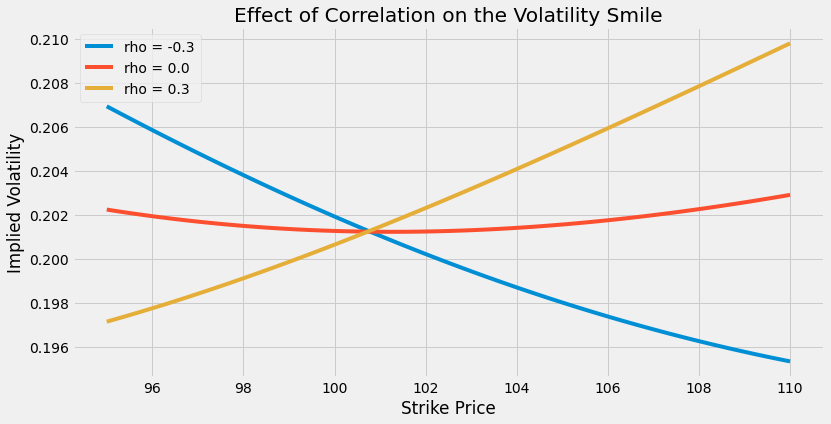

In [22]:
strikes = np.linspace(95, 110, 100)

fig, ax = plt.subplots(figsize = (12, 6))
for model in hestons:
    implied_volatilities = [impliedVolatility(model, strike, S, tau, upper = 100) for strike in strikes]
    ax.plot(strikes, implied_volatilities, label = f'rho = {model.rho}')

ax.set_title('Effect of Correlation on the Volatility Smile')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.legend(loc = 'best')
plt.show()

We see that the correlation affects the steepness of the smile.

Below, we study the effects of the vol-of-vol on the volatility smile.

In [23]:
sigmas = [0.35, 0.55, 0.80]
hestons = [Heston(r, v0, kappa, theta, eta, rho, sigma) for sigma in sigmas]

As before, one may verify that the characteristic functions of these models die of sufficiently by $\phi = 100$. Plotting the results, we obtain the following plot:

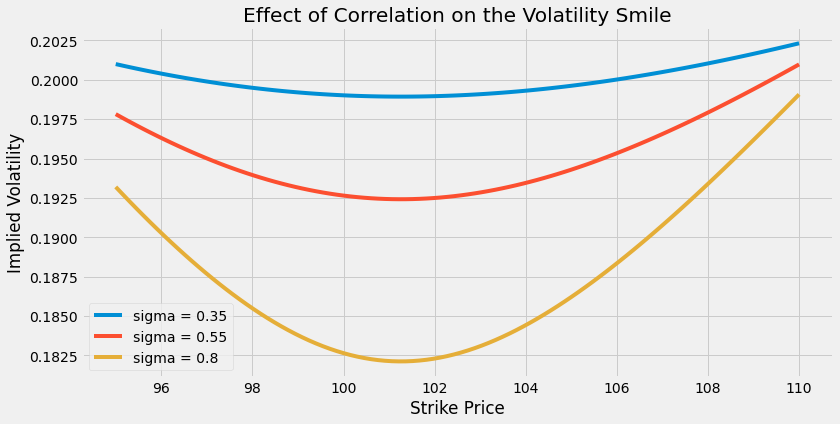

In [24]:
fig, ax = plt.subplots(figsize = (12, 6))
for model in hestons:
    implied_volatilities = [impliedVolatility(model, strike, S, tau, upper = 100) for strike in strikes]
    ax.plot(strikes, implied_volatilities, label = f'sigma = {model.sigma}')

ax.set_title('Effect of Correlation on the Volatility Smile')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.legend(loc = 'best')
plt.show()

Here, we see that the vol-of-vol affects the deepness of the volatility smile.

We now consider the effect of the volatility mean-reversion rate $\kappa$.

In [25]:
this_sigma = 0.2
this_v0 = 0.01
kappas = [5.0, 2.0, 1.0]
hestons = [Heston(r, this_v0, kappa, theta, eta, rho, this_sigma) for kappa in kappas]

In this case, one may verify that the characteristic function of the $\kappa = 5.0$ model is still oscllating noticeably at $\phi = 100$ and so we extend the range of integration to $\phi = 200$ to be safe.

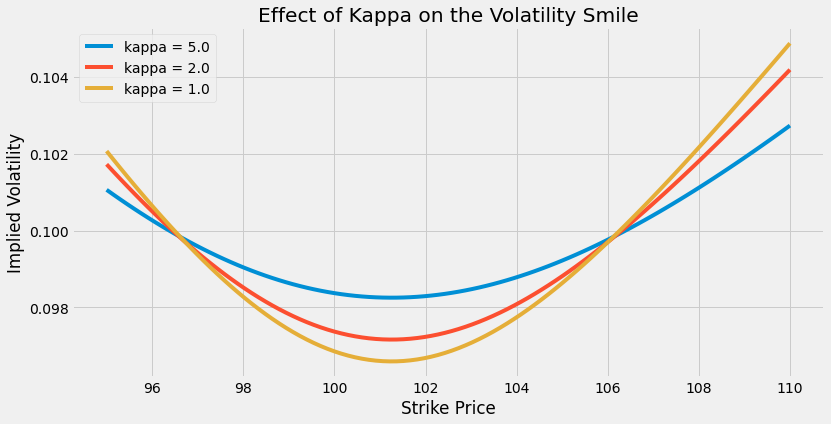

In [26]:
fig, ax = plt.subplots(figsize = (12, 6))
for model in hestons:
    implied_volatilities = [impliedVolatility(model, strike, S, tau, upper = 200) for strike in strikes]
    ax.plot(strikes, implied_volatilities, label = f'kappa = {model.kappa}')

ax.set_title('Effect of Kappa on the Volatility Smile')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.legend(loc = 'best')
plt.show()

We thus conclude that $\kappa$ controls the width of the smile.

Next we plot the effect of the long-term mean of the volatility on the smile.

In [27]:
this_sigma = 0.5
thetas = [0.020, 0.015, 0.010]
hestons = [Heston(r, v0, kappa, theta, eta, rho, this_sigma) for theta in thetas]

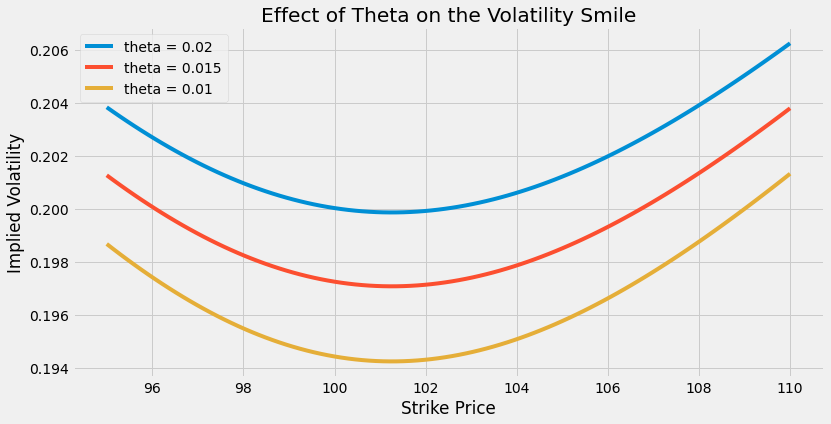

In [28]:
fig, ax = plt.subplots(figsize = (12, 6))
for model in hestons:
    implied_volatilities = [impliedVolatility(model, strike, S, tau, upper = 100) for strike in strikes]
    ax.plot(strikes, implied_volatilities, label = f'theta = {model.theta}')

ax.set_title('Effect of Theta on the Volatility Smile')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.legend(loc = 'best')
plt.show()

We see that $\theta$ controls the absolute position of the smile; a higher long-term mean volatility results in a higher implied volatilty, as one might expect.

Finally, we study the effect of the initial volatility $v_0$ on the smile.

In [29]:
this_sigma = 0.5
v0s = [0.020, 0.015, 0.010]
hestons = [Heston(r, v0, kappa, theta, eta, rho, this_sigma) for v0 in v0s]

One may verify that the characteristic functions of these three models are particularly long-tailed and so we extend the domain of integration out to $\phi = 300$.

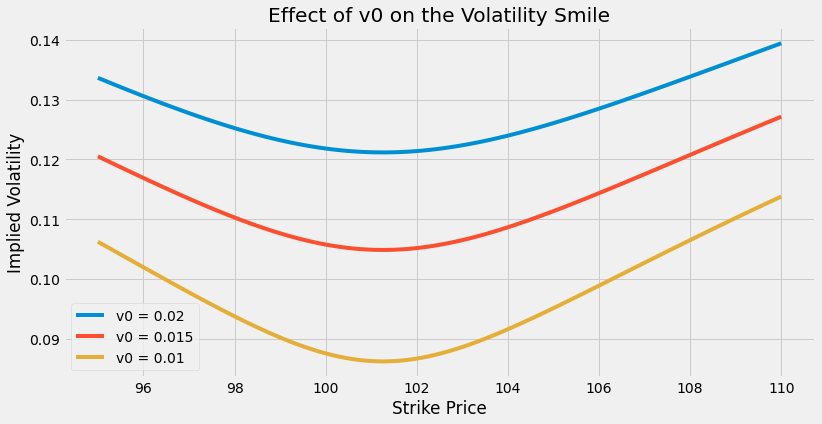

In [30]:
fig, ax = plt.subplots(figsize = (12, 6))
for model in hestons:
    implied_volatilities = [impliedVolatility(model, strike, S, tau, upper = 300) for strike in strikes]
    ax.plot(strikes, implied_volatilities, label = f'v0 = {model.v0}')

ax.set_title('Effect of v0 on the Volatility Smile')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.legend(loc = 'best')
plt.show()